Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Step 1: Cleaning corrupted and blurry images...
Found 1581 images.
Cleaned dataset saved to: /content/drive/MyDrive/cleaned_dataset
Total blurry: 0, Corrupted: 0
Step 2: Resizing images to 640x640...


Resizing Motorcycles: 100%|██████████| 793/793 [00:35<00:00, 22.40it/s]


Resized dataset saved to: /content/drive/MyDrive/resized_dataset
Step 3: Normalizing images to [0,1]...


Normalizing Motorcycles: 100%|██████████| 793/793 [02:52<00:00,  4.59it/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Normalized dataset saved to: /content/drive/MyDrive/normalized_dataset
Step 4: Removing outliers...


Extracting features: 100%|██████████| 50/50 [21:13<00:00, 25.48s/it]


Dataset without outliers saved to: /content/drive/MyDrive/no_outliers_dataset
Step 5: Visualizing class distribution...


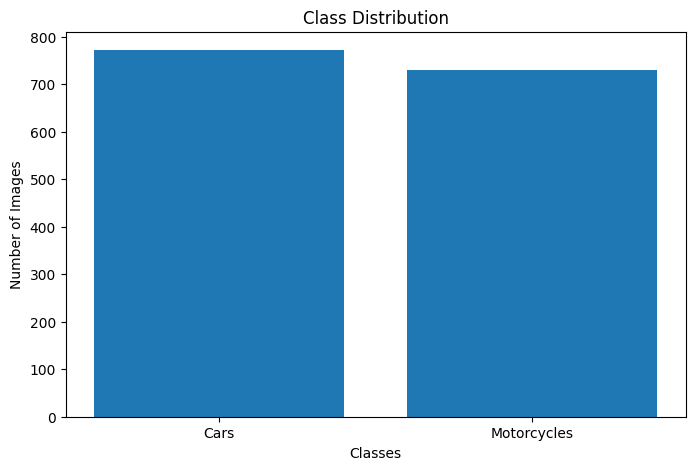

Class distribution saved to /content/class_distribution.xlsx
Step 6: Balancing dataset with augmentation...
Balanced dataset saved to: /content/drive/MyDrive/balanced_dataset
Step 7: Extracting features for EDA...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting VGG features: 100%|██████████| 49/49 [20:54<00:00, 25.60s/it]


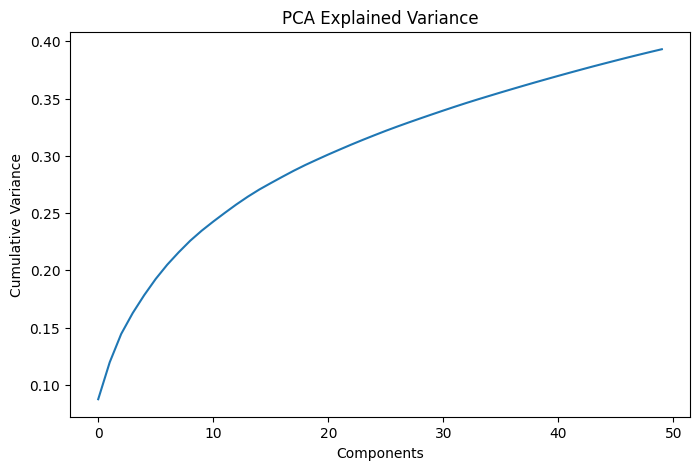

PCA features saved to: /content/drive/MyDrive/eda_features.csv
Pipeline complete! Final balanced dataset at: /content/drive/MyDrive/balanced_dataset
EDA features at: /content/drive/MyDrive/eda_features.csv


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
!pip install opencv-python imutils torch torchvision scikit-learn pillow pandas matplotlib tqdm numpy scipy

# Imports
import os
import shutil
import numpy as np
import pandas as pd
import cv2
from imutils import paths
from PIL import Image
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets.folder import IMG_EXTENSIONS
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmentation
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths (chainable: each step's output is next step's input)
ORIGINAL_DIR = '/content/drive/MyDrive/Vehicles'
CLEANED_DIR = '/content/drive/MyDrive/cleaned_dataset'  # After cleaning corrupted/blurry
RESIZED_DIR = '/content/drive/MyDrive/resized_dataset'  # 640x640, with subfolders
NORMALIZED_DIR = '/content/drive/MyDrive/normalized_dataset'  # 0-1 normalized, with subfolders
NO_OUTLIERS_DIR = '/content/drive/MyDrive/no_outliers_dataset'  # After removing outliers
BALANCED_DIR = '/content/drive/MyDrive/balanced_dataset'  # After augmentation
EDA_FEATURES_FILE = '/content/drive/MyDrive/eda_features.csv'  # PCA features for EDA

# Create output directories if needed
for dir_path in [CLEANED_DIR, RESIZED_DIR, NORMALIZED_DIR, NO_OUTLIERS_DIR, BALANCED_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Helper: Get all image paths recursively, filtered by extensions
def get_image_paths(root_dir):
    image_paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(IMG_EXTENSIONS):
                image_paths.append(os.path.join(root, f))
    return sorted(image_paths)

# Step 1: Clean corrupted/missing/blurry images
# - Copy original to CLEANED_DIR, remove corrupted, move blurry to 'blurred' subfolder
def clean_images(input_dir, output_dir):
    print("Step 1: Cleaning corrupted and blurry images...")

    # Copy original structure to output_dir
    for subdir in ['Cars', 'Motorcycles']:
        src = os.path.join(input_dir, subdir)
        dst = os.path.join(output_dir, subdir)
        if os.path.exists(src):
            shutil.copytree(src, dst, dirs_exist_ok=True)

    image_paths = get_image_paths(output_dir)
    print(f"Found {len(image_paths)} images.")

    # Detect corrupted
    corrupted_images = []
    for path in image_paths:
        try:
            img = cv2.imread(path)
            if img is None:
                corrupted_images.append(path)
        except:
            corrupted_images.append(path)

    for path in corrupted_images:
        os.remove(path)
        print(f"Removed corrupted: {path}")

    # Detect blurry (Laplacian variance < 500)
    def variance_of_laplacian(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            return cv2.Laplacian(gray, cv2.CV_64F).var()
        return 0

    blur_threshold = 500.0
    blurry_images = [path for path in image_paths if variance_of_laplacian(path) < blur_threshold]

    # Move blurry to 'blurred' folder in output_dir
    blurred_folder = os.path.join(output_dir, 'blurred')
    os.makedirs(blurred_folder, exist_ok=True)
    for path in blurry_images:
        filename = os.path.basename(path)
        shutil.move(path, os.path.join(blurred_folder, filename))
        print(f"Moved blurry: {path} to {blurred_folder}")

    print(f"Cleaned dataset saved to: {output_dir}")
    print(f"Total blurry: {len(blurry_images)}, Corrupted: {len(corrupted_images)}")

clean_images(ORIGINAL_DIR, CLEANED_DIR)

# Step 2: Resizing/Rescaling to 640x640 (maintain subfolders)
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    print("Step 2: Resizing images to 640x640...")
    classes = [cls for cls in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, cls)) and cls != 'blurred']

    for cls in classes:
        cls_input = os.path.join(input_dir, cls)
        cls_output = os.path.join(output_dir, cls)
        os.makedirs(cls_output, exist_ok=True)

        image_paths = get_image_paths(cls_input)
        for path in tqdm(image_paths, desc=f"Resizing {cls}"):
            try:
                img = Image.open(path).convert('RGB')  # Ensure 3 channels
                img = img.resize(target_size, Image.Resampling.LANCZOS) # Changed ANTIALIAS to LANCZOS
                base_name = os.path.basename(path)
                img.save(os.path.join(cls_output, base_name))
            except Exception as e:
                print(f"Error resizing {path}: {e}")

    print(f"Resized dataset saved to: {output_dir}")

resize_images(CLEANED_DIR, RESIZED_DIR)

# Step 3: Normalization to [0,1] (save as PNGs, maintain subfolders)
def normalize_images(input_dir, output_dir):
    print("Step 3: Normalizing images to [0,1]...")
    transform = transforms.Compose([
        transforms.ToTensor()  # Normalizes to [0,1]
    ])

    classes = [cls for cls in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, cls))]
    for cls in classes:
        cls_input = os.path.join(input_dir, cls)
        cls_output = os.path.join(output_dir, cls)
        os.makedirs(cls_output, exist_ok=True)

        image_paths = get_image_paths(cls_input)
        for path in tqdm(image_paths, desc=f"Normalizing {cls}"):
            try:
                img = Image.open(path).convert('RGB')
                tensor = transform(img)
                pil_img = transforms.ToPILImage()(tensor)  # Back to PIL for saving
                base_name, ext = os.path.splitext(os.path.basename(path))
                new_name = f"{base_name}_normalized.png"
                pil_img.save(os.path.join(cls_output, new_name))
            except Exception as e:
                print(f"Error normalizing {path}: {e}")

    print(f"Normalized dataset saved to: {output_dir}")

normalize_images(RESIZED_DIR, NORMALIZED_DIR)

# Step 4: Remove outliers/noisy images (using Isolation Forest on VGG16 features)
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = get_image_paths(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, path  # Return image and path

def remove_outliers(input_dir, output_dir):
    print("Step 4: Removing outliers...")

    # VGG16 for feature extraction
    model = models.vgg16(pretrained=True).features.to(device)
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageDataset(input_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    features = []
    paths = []
    with torch.no_grad():
        for imgs, batch_paths in tqdm(loader, desc="Extracting features"):
            imgs = imgs.to(device)
            feats = model(imgs).flatten(1).cpu().numpy()
            features.extend(feats)
            paths.extend(batch_paths)

    features = np.array(features)

    # Check if features array is empty
    if features.shape[0] == 0:
        print("No features extracted. Skipping outlier removal.")
        # Copy all images from input to output if no features are extracted
        for path in get_image_paths(input_dir):
            rel_path = os.path.relpath(path, input_dir)
            dst_path = os.path.join(output_dir, rel_path)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(path, dst_path)
        return


    # Isolation Forest for outliers
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(features)

    # Copy non-outliers to output_dir (maintain structure)
    for i, path in enumerate(paths):
        if outliers[i] == 1:  # 1 = normal, -1 = outlier
            rel_path = os.path.relpath(path, input_dir)
            dst_path = os.path.join(output_dir, rel_path)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(path, dst_path)

    print(f"Dataset without outliers saved to: {output_dir}")

remove_outliers(NORMALIZED_DIR, NO_OUTLIERS_DIR)

# Step 5: Check and visualize class distribution
def visualize_class_distribution(input_dir):
    print("Step 5: Visualizing class distribution...")
    class_counts = {}
    classes = [cls for cls in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, cls))]
    for cls in classes:
        class_path = os.path.join(input_dir, cls)
        class_counts[cls] = len(get_image_paths(class_path))

    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
    df.to_excel('/content/class_distribution.xlsx', index=False)

    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

    print("Class distribution saved to /content/class_distribution.xlsx")
    return class_counts

class_counts = visualize_class_distribution(NO_OUTLIERS_DIR)

# Step 6: Balance dataset using augmentation
def balance_dataset(input_dir, output_dir, class_counts):
    print("Step 6: Balancing dataset with augmentation...")
    max_count = max(class_counts.values())
    datagen = ImageDataGenerator(
        rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
        zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    )

    classes = list(class_counts.keys())
    for cls in classes:
        cls_input = os.path.join(input_dir, cls)
        cls_output = os.path.join(output_dir, cls)
        os.makedirs(cls_output, exist_ok=True)

        # Copy existing images
        for path in get_image_paths(cls_input):
            shutil.copy(path, cls_output)

        current_count = class_counts[cls]
        to_generate = max_count - current_count
        if to_generate > 0:
            image_paths = get_image_paths(cls_input)
            generated = 0
            while generated < to_generate:
                for path in image_paths:
                    if generated >= to_generate:
                        break
                    img = np.expand_dims(np.array(Image.open(path)), 0)
                    for batch in datagen.flow(img, batch_size=1):
                        pil_img = Image.fromarray(np.uint8(batch[0]))
                        pil_img.save(os.path.join(cls_output, f"aug_{generated}_{os.path.basename(path)}"))
                        generated += 1
                        break  # One augmentation per flow call

    print(f"Balanced dataset saved to: {output_dir}")

balance_dataset(NO_OUTLIERS_DIR, BALANCED_DIR, class_counts)

# Step 7: Extract features (PCA on VGG16 features) for EDA
def extract_features_for_eda(input_dir, output_file):
    print("Step 7: Extracting features for EDA...")

    # VGG16 features
    model = models.vgg16(pretrained=True).features.to(device)
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageDataset(input_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    features = []
    labels = []
    with torch.no_grad():
        for imgs, batch_paths in tqdm(loader, desc="Extracting VGG features"):
            imgs = imgs.to(device)
            feats = model(imgs).flatten(1).cpu().numpy()
            features.extend(feats)
            # Infer label from path (e.g., 'Cars' or 'Motorcycles')
            batch_labels = [os.path.relpath(p, input_dir).split(os.sep)[0] for p in batch_paths]
            labels.extend(batch_labels)

    features = np.array(features)

    # PCA reduction (e.g., to 50 components)
    pca = PCA(n_components=50)
    reduced_features = pca.fit_transform(features)

    # Save to CSV for EDA
    df = pd.DataFrame(reduced_features)
    df['label'] = labels
    df.to_csv(output_file, index=False)

    # Visualize explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA Explained Variance')
    plt.xlabel('Components')
    plt.ylabel('Cumulative Variance')
    plt.show()

    print(f"PCA features saved to: {output_file}")

extract_features_for_eda(BALANCED_DIR, EDA_FEATURES_FILE)

print("Pipeline complete! Final balanced dataset at:", BALANCED_DIR)
print("EDA features at:", EDA_FEATURES_FILE)